# Final Regression Model

In [3]:
import os

import math
import pandas as pd
import numpy as np
import datetime as dt
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 63)
pd.set_option('display.precision', 3)

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Load Dataset
- Fix errors in dataset that were uncovered during analysis/modeling
- Remove features not useful for analysis (e.g. headliner, support names)
    - Possible feature: number of times someone headlines
- Convert column datatypes

In [8]:
with open('Data/ticket_final.pkl','rb') as read_file:
    ticket_final_df = pickle.load(read_file)

In [9]:
ticket_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 25 columns):
event_date           858 non-null object
year                 858 non-null int64
month                858 non-null object
season               858 non-null object
day_of_week          858 non-null object
time_of_week         858 non-null object
num_shows            858 non-null int64
show_type            858 non-null object
headliner            858 non-null object
support              858 non-null object
num_support          858 non-null int64
tickets_sold         858 non-null float64
gross_usd            858 non-null float64
venue_capacity       858 non-null float64
percentage_sold      858 non-null float64
ticket_price_min     858 non-null float64
ticket_price_max     858 non-null float64
artist_start_date    858 non-null float64
years_active         858 non-null int64
artist_hometown      858 non-null object
us_region            858 non-null object
local_or_not         858 non-nu

## Fix dataset errors 

In [4]:
ticket_final_df.loc[649, 'artist_genre'] = 'Hip Hop'
ticket_final_df.loc[662, 'gross_usd'] = 307039
ticket_final_df.loc[663, 'gross_usd'] = 307039
ticket_final_df.loc[682, 'artist_genre'] = 'Podcast'
ticket_final_df.loc[759, 'artist_genre'] = 'Hip Hop'
ticket_final_df.loc[796, 'years_active'] = 48
# ticket_final_df.loc[796, 'artist_genre'] = 'Pop'
# ticket_final_df.loc[525, 'artist_start_date'] = 2014
# ticket_final_df.loc[544, 'artist_start_date'] = 2012
# ticket_final_df.loc[574, 'artist_start_date'] = 2013
# ticket_final_df.loc[681, 'artist_start_date'] = 2012
# ticket_final_df.loc[721, 'artist_start_date'] = 2017
# ticket_final_df.loc[774, 'artist_start_date'] = 2013
# ticket_final_df.loc[775, 'artist_start_date'] = 2013
# ticket_final_df.loc[833, 'artist_start_date'] = 1996
# ticket_final_df.loc[848, 'artist_start_date'] = 2011

In [5]:
ticket_final_df[ticket_final_df.artist_genre == 'Religious']

,event_date,year,month,season,day_of_week,time_of_week,num_shows,show_type,headliner,support,num_support,tickets_sold,gross_usd,venue_capacity,percentage_sold,ticket_price_min,ticket_price_max,artist_start_date,years_active,artist_hometown,us_region,local_or_not,miles_from_home,artist_genre,main_genre
758,2018-09-18,2018,September,Autumn,Tuesday,Weekday,1,single headliner,Needtobreathe,"Forest Blakk, Johnnyswim",2,1800.0,88176.0,2200.0,82.0,46.0,66.0,2001.0,17,"Seneca, South Carolina, United States",South,US,2190.241,Religious,christian rock
853,2019-08-14,2019,August,Summer,Wednesday,Weekday,1,single headliner,Kirk Franklin,Travele Judon,1,1288.0,85120.0,1847.0,70.0,45.0,85.0,1993.0,26,"Fort Worth, Texas, United States",South,US,1447.369,Religious,gospel


## Remove unnecessary features

1. event_date
2. headliner
3. tickets_sold (directly related to gross_usd)
4. support
5. artist_start_date
6. artist_hometown
7. main_genre

In [6]:
gross_usd_model_df = ticket_final_df[[
                                      'gross_usd',
#                                       'year',
                                      'month',
                                      'season',
                                      'day_of_week',
                                      'time_of_week',
                                      'show_type',
                                      'num_shows',
                                      'num_support',
                                      'ticket_price_min',
                                      'ticket_price_max',
                                      'venue_capacity',
                                      'percentage_sold',
                                      'years_active',
                                      'us_region',
                                      'local_or_not',
                                      'miles_from_home',
                                      'artist_genre'
                                      ]]

## Convert `year` datatype to string
- Will be used to generate dummy variables for that feature

In [7]:
# gross_usd_model_df = gross_usd_model_df.astype({
#                                                 'year': 'str' 
#                                                 'num_shows': 'str'
#                                                })

In [8]:
gross_usd_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 17 columns):
gross_usd           858 non-null float64
month               858 non-null object
season              858 non-null object
day_of_week         858 non-null object
time_of_week        858 non-null object
show_type           858 non-null object
num_shows           858 non-null int64
num_support         858 non-null int64
ticket_price_min    858 non-null float64
ticket_price_max    858 non-null float64
venue_capacity      858 non-null float64
percentage_sold     858 non-null float64
years_active        858 non-null int64
us_region           858 non-null object
local_or_not        858 non-null object
miles_from_home     858 non-null float64
artist_genre        858 non-null object
dtypes: float64(6), int64(3), object(8)
memory usage: 114.1+ KB


# Preliminary EDA - Target Analysis

- **Analyze the Target**
    - What are the summary metrics?
    - What does the distribution look like?
    - Are there any outliers?

## Summary Metrics

- There may definitely be some outliers here that are worth looking into.
    - Mean: \$102,142  
    - Minimum: \$4,464
    - Maximum: \$312,414

In [9]:
gross_usd_model_df.gross_usd.describe()

count       858.000
mean     102500.002
std       42253.180
min        4464.000
25%       76202.000
50%       95755.500
75%      118906.250
max      312414.333
Name: gross_usd, dtype: float64

## Distribution

(array([ 49., 254., 306., 135.,  52.,  33.,  13.,   2.,   5.,   8.]),
 array([ 25850.        ,  54506.43333333,  83162.86666667, 111819.3       ,
        140475.73333333, 169132.16666667, 197788.6       , 226445.03333333,
        255101.46666667, 283757.9       , 312414.33333333]),
 <a list of 10 Patch objects>)

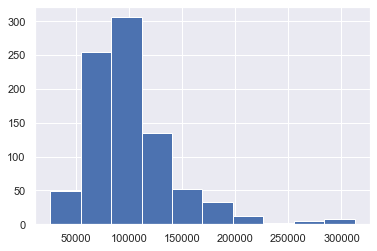

In [98]:
plt.hist(gross_usd_model_df.gross_usd)

## Outliers

- Generate box-whisker plot to identify outliers. How will the model interpret them? They are not mistakes in the dataset, but they are simply extreme values. It will need to be determined if they get removed or not.
- **The box-whisker plot identified about 4% of the data as outliers**

In [11]:
# - Through further exploration, it is clear that the outliers are not representative of the average Fox Theater show. They were influenced by a couple factors:
#     - Large outliers:
#         - expensive ticket prices
#             - e.g. Van Morrison shows selling floor tickets at \$250)
#     - Small outliers:
#         - Small venue capacity and low ticket prices
#             - e.g. John Vanderslice show selling tickets for \$16 and only having 300 seats available
#             - Would only generate \$4,800 gross

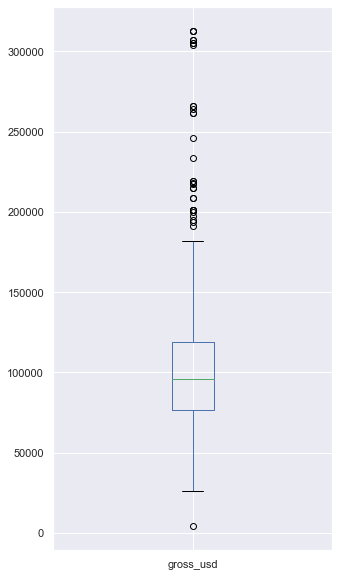

In [12]:
fig = plt.figure(figsize = [5,10])
pd.DataFrame(gross_usd_model_df.gross_usd).boxplot()

In [13]:
q25, q50, q75 = np.percentile(gross_usd_model_df.gross_usd, [25, 50, 75])
iqr = q75 - q25

In [14]:
outlier_dict = {}

min = q25 - 1.5*iqr
max = q75 + 1.5*iqr

for index, value in gross_usd_model_df.gross_usd.iteritems():
    if value > max or value < min:
        outlier_dict[index] = value

In [15]:
# Drop the following outliers

gross_usd_model_df.drop([
                         23,
#                          172,
#                          713,
#                          758,
#                          795, 
#                          796, 
#                          852,
#                          853
                        ], inplace=True)

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Feature Toggles

- These features are multicollinear; there can only be one of each

## Min Ticket Price vs Max Ticket Price vs Ticket Range

In [16]:
ticket_range = gross_usd_model_df.ticket_price_max - gross_usd_model_df.ticket_price_min

In [17]:
gross_usd_model_df.insert(10, 'ticket_range', ticket_range)

In [18]:
# gross_usd_model_df.drop('ticket_range', axis=1, inplace=True)

In [19]:
# gross_usd_model_df.drop('ticket_price_min', axis=1, inplace=True)

In [20]:
gross_usd_model_df.drop('ticket_price_max', axis=1, inplace=True)

## Venue Capacity vs Percent Tickets Sold
- Using these two features, the number of tickets sold can be calculated

In [21]:
# gross_usd_model_df.drop('venue_capacity', axis=1, inplace=True)

In [22]:
gross_usd_model_df.drop('percentage_sold', axis=1, inplace=True)

## Day of Week vs Time of Week

In [23]:
gross_usd_model_df.drop('day_of_week', axis=1, inplace=True)

In [24]:
gross_usd_model_df.drop('time_of_week', axis=1, inplace=True)

## Month vs Season

In [25]:
# gross_usd_model_df.drop('month', axis=1, inplace=True)

In [26]:
gross_usd_model_df.drop('season', axis=1, inplace=True)

## Number of Shows vs Show Type vs Number of Supporting Acts

In [27]:
gross_usd_model_df.drop('num_support', axis=1, inplace=True)

In [28]:
# gross_usd_model_df.drop('num_shows', axis=1, inplace=True)

In [29]:
gross_usd_model_df.drop('show_type', axis=1, inplace=True)

## Miles from Home vs US Region vs Local or Not

In [30]:
gross_usd_model_df.drop('miles_from_home', axis=1, inplace=True)

In [31]:
gross_usd_model_df.drop('us_region', axis=1, inplace=True)

In [32]:
# gross_usd_model_df.drop('local_or_not', axis=1, inplace=True)

# Add Dummy Variables

- Dummy variables need to be created for the following features:
    1. month
    2. season
    3. day_of_week
    4. time_of_week
    5. show_type
    6. us_region
    7. local_or_not
    8. artist_genre

In [33]:
gross_usd_model_df = pd.get_dummies(gross_usd_model_df, drop_first=True)

# Train-Test Split

In [34]:
X = gross_usd_model_df.drop('gross_usd', axis=1)
y = gross_usd_model_df.gross_usd

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=X.artist_genre_Religious)

# EDA

**Initial Takeaways**
- Mean and median gross revenue both hover around $100K.
- There is a high correlation between max and min ticket prices, which is understandable.  Collinearity will need to be checked between these features.
- There is a high correlation between ticket price and gross revenue, which is also understandable.  This is acceptable though, as there is not a directly linear relationship (i.e. you cannot necessarily increase the ticket price and expect more revenue).

In [36]:
eda_df = X_train.copy()

In [37]:
eda_df.insert(0, 'gross_usd', y_train)

In [38]:
eda_df.describe()

,gross_usd,num_shows,ticket_price_min,ticket_range,venue_capacity,years_active,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,local_or_not_Local,local_or_not_US,artist_genre_Children Music,artist_genre_Comedy,artist_genre_Country,artist_genre_Electronic,artist_genre_Experimental,artist_genre_Folk,artist_genre_Hip Hop,artist_genre_Indie,artist_genre_Jazz,artist_genre_Metal,artist_genre_Podcast,artist_genre_Pop,artist_genre_Punk,artist_genre_Reggae,artist_genre_Religious,artist_genre_Rock,artist_genre_Soul,artist_genre_World
count,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000,685.000
mean,102468.278,1.282,39.149,11.717,2636.915,13.318,0.054,0.072,0.093,0.038,0.042,0.051,0.109,0.098,0.092,0.123,0.105,0.061,0.626,0.007,0.023,0.023,0.109,0.009,0.092,0.079,0.172,0.006,0.032,0.007,0.091,0.035,0.010,0.003,0.191,0.035,0.006
std,41245.867,0.517,11.700,27.928,370.179,12.503,0.226,0.258,0.291,0.191,0.202,0.220,0.312,0.297,0.289,0.328,0.307,0.240,0.484,0.085,0.151,0.151,0.312,0.093,0.289,0.270,0.378,0.076,0.176,0.085,0.287,0.184,0.101,0.054,0.394,0.184,0.076
min,25850.000,1.000,19.500,0.000,1020.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,75850.000,1.000,29.500,0.000,2800.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,95795.000,1.000,35.000,2.500,2800.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,119000.000,1.000,45.000,10.000,2800.000,19.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,312414.333,3.000,99.500,445.000,3007.000,59.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [39]:
eda_df.corr().style.background_gradient()

In [40]:
# plt.figure(figsize = [40,20])
# sns.heatmap(round(eda_df.corr(), 2), annot=True, cmap='YlGnBu')

# Feature Engineering

In [41]:
# sns.pairplot(eda_df[eda_df.columns[:5]])

## Boxcox Transformations

In [42]:
def boxcox(X_train, X_test, feature):
    x_feature = X_train[feature]
    x_feature_box_train, fitted_lambda = stats.boxcox(x_feature)
    x_feature_box_test = stats.boxcox(X_test[feature], fitted_lambda)
    
    return x_feature_box_train, x_feature_box_test, fitted_lambda

In [43]:
# transform_train_dict = {}
# transform_test_dict = {}

In [44]:
# list(eda_df.columns[1:5])

In [45]:
boxcox_features = [
#                    'ticket_price_min', 
#                    'ticket_range', 
#                    'venue_capacity',
#                    'years_active'
                  ]

In [46]:
# for column in boxcox_features:
#     if round(np.min(X_train[column].values) == 0):
#         x_transform_train, x_transform_test = (X_train[column])**(1/3), (X_test[column])**(1/3)
#         transform_train_dict[column] = ('cube', x_transform_train)
#         transform_test_dict[column] = ('cube', x_transform_test)
#         plt.hist(x_transform_train)
#         plt.title(column+'_cube_root')
#         plt.show()
# #     elif column == 'venue_capacity':
# #         transform_train_dict[column] = ('bimodal', abs(X_train[column].values - np.mean(X_train[column].values)))
# #         transform_test_dict[column] = ('bimodal', abs(X_test[column].values - np.mean(X_test[column].values)))
# #         plt.hist(abs(X_train[column].values - np.mean(X_train[column])))
# #         plt.title(column+'_bimodal')
# #         plt.show()
#     else:
#         x_feature_box_train, x_feature_box_test, fit_lambda = boxcox(X_train, X_test, column)
#         transform_train_dict[column] = (fit_lambda, x_feature_box_train)
#         transform_test_dict[column] = (fit_lambda, x_feature_box_test)
#         plt.hist(x_feature_box_train)
#         plt.title(column+'_boxcox')
#         plt.show()

In [47]:
# for column, value in transform_train_dict.items():
#     X_train[column] = value[1]

In [48]:
# for column, value in transform_test_dict.items():
#     X_test[column] = value[1]

# Standardization

In [49]:
std = StandardScaler()
std.fit(X_train.values)

X_tr_scaled = std.transform(X_train.values)
X_te_scaled = std.transform(X_test.values)

X_tr = pd.DataFrame(X_tr_scaled, index = X_train.index, columns = X_train.columns)
X_te = pd.DataFrame(X_te_scaled, index = X_test.index, columns = X_test.columns)

---

# Baseline Model

- Based on toggles above, different target/feature scenarios can be evaluated.  The one below provides the best results when taking R-squared, Adj R-squared, AIC, BIC, Condition Number, etc. into account
    - This model has the following characteristics:
        - No target transformations
        - Dropped outliers
        - Two sets of features dropped due to regularization and poor p-values
        - Includes month and day of week features

In [50]:
model1 = sm.OLS(y_train, sm.add_constant(X_tr))
fit = model1.fit()

fit.summary()

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              gross_usd   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     125.8
Date:                Thu, 16 Jul 2020   Prob (F-statistic):          8.55e-266
Time:                        18:44:07   Log-Likelihood:                -7539.4
No. Observations:                 685   AIC:                         1.515e+04
Df Residuals:                     648   BIC:                         1.532e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                        1.025e+05    572.822    178.883      0.000    1.01e+05    1.04e+05
num_shows                    2399.0803    628.616      3.816      0.000    1164.710    3633.450
ticket_price_min             3.275e+04    831.045     39.407      0.000    3.11e+04    3.44e+04
ticket_range                 9405.2801    767.534     12.254      0.000    7898.127    1.09e+04
venue_capacity               1.407e+04    773.394     18.195      0.000    1.26e+04    1.56e+04
years_active                 3385.3806    824.503      4.106      0.000    1766.361    5004.401
month_August                 -354.6905    681.932     -0.520      0.603   -1693.754     984.373
month_December                374.3640    736.389      0.508      0.611   -1071.633    1820.361
month_February                504.5362    752.584      0.670      0.503    -973.262    1982.334
month_January                 480.0193    667.294      0.719      0.472    -830.301    1790.340
month_July                   -356.0943    678.669     -0.525      0.600   -1688.751     976.562
month_June                  -1464.3235    685.673     -2.136      0.033   -2810.733    -117.914
month_March                  -469.3875    767.552     -0.612      0.541   -1976.578    1037.803
month_May                    -868.5736    748.690     -1.160      0.246   -2338.726     601.579
month_November               -484.4305    740.807     -0.654      0.513   -1939.104     970.243
month_October                -802.1152    776.123     -1.033      0.302   -2326.134     721.903
month_September             -1490.8572    749.623     -1.989      0.047   -2962.840     -18.874
local_or_not_Local            506.3011    670.473      0.755      0.450    -810.260    1822.862
local_or_not_US             -1922.5772    681.335     -2.822      0.005   -3260.468    -584.687
artist_genre_Children Music  2349.6553    659.058      3.565      0.000    1055.508    3643.803
artist_genre_Comedy          2193.5399    688.970      3.184      0.002     840.657    3546.423
artist_genre_Country            3.5091    669.759      0.005      0.996   -1311.652    1318.670
artist_genre_Electronic      1060.8579    948.877      1.118      0.264    -802.386    2924.102
artist_genre_Experimental      99.5385    619.567      0.161      0.872   -1117.063    1316.140
artist_genre_Folk             632.2023    875.260      0.722      0.470   -1086.486    2350.891
artist_genre_Hip Hop          806.2899    855.595      0.942      0.346    -873.783    2486.362
artist_genre_Indie           1200.4428   1043.445      1.150      0.250    -848.499    3249.384
artist_genre_Jazz            1208.4688    608.784      1.985      0.048      13.041    2403.897
artist_genre_Metal           2449.8636    719.800      3.404      0.001    1036.442    3863.286
artist_genr

## Baseline Evaluation

In [51]:
def lin_reg(X_train, y_train):
    
    lin_reg = LinearRegression()
    score1 = cross_val_score(lin_reg, X_train, y_train, cv=5)
    score2 = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    score3 = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    
    print('r2 score:', score1.mean())
    print('MAE: $', (score2*-1).mean())
    print('RMSE: $', (score3*-1).mean())
    
    return

In [52]:
lin_reg(X_tr, y_train)

r2 score: 0.84871540851995
MAE: $ 11403.949324062116
RMSE: $ 15638.765678508184


## Model Analysis and Improvements

### Residual Distribution

- Residuals looks to be fairly normally distributed around 0

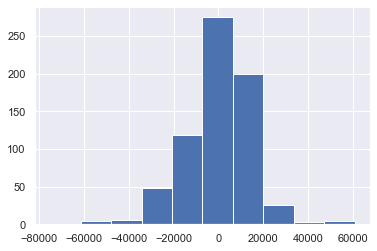

In [53]:
fit.resid.hist()

### Predicted vs Residual Plot

Text(0, 0.5, 'Residual $')

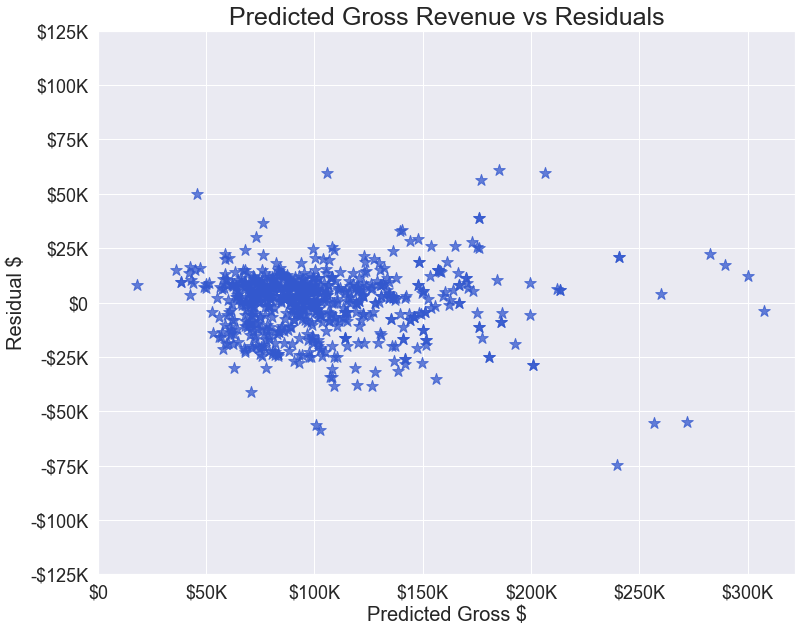

In [54]:
# Looks fairly normally distributed

plt.figure(figsize = [12.5,10])
plt.scatter(fit.predict(), fit.resid, s = 150, color = '#3358CE', marker = '*', alpha = 0.75)
plt.title('Predicted Gross Revenue vs Residuals', fontsize = 25)
plt.xticks(np.arange(0,350000, step = 50000), ('$0', '$50K', '$100K', '$150K', '$200K', '$250K', '$300K'), fontsize = 18)
plt.yticks(np.arange(-125000,150000, step = 25000), ('-$125K', '-$100K', '-$75K', '-$50K', '-$25K', '$0', '$25K', '$50K', '$75K', '$100K', '$125K', '$150K'), fontsize = 18)
plt.xlabel('Predicted Gross $', fontsize = 20)
plt.ylabel('Residual $', fontsize = 20)

### QQ Plot

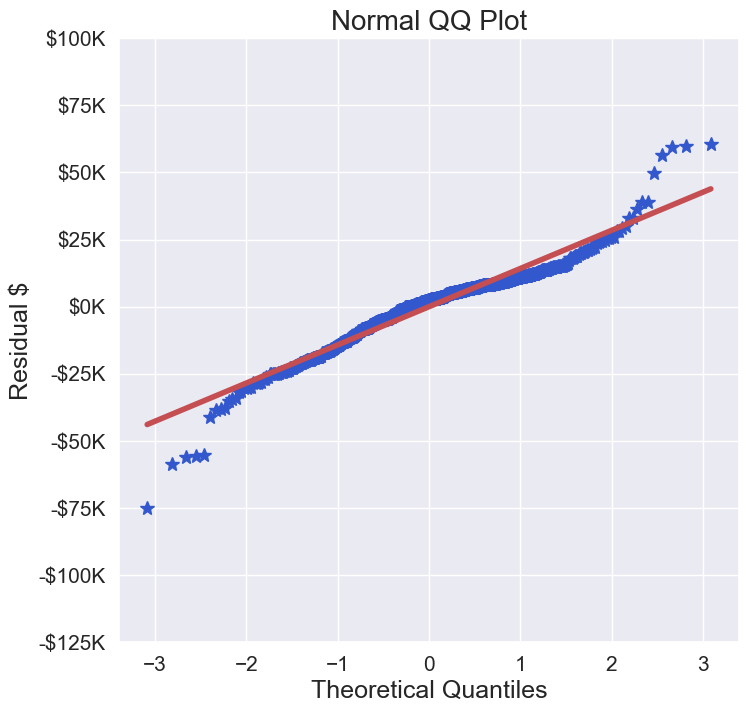

In [55]:
# Residuals are in a fairly straight line which indicates a somewhat normal distribution.

import pylab 
import scipy.stats as stats

fig = plt.figure(figsize=[8,8], dpi=100)
ax = fig.add_subplot(111)
fig = stats.probplot(fit.resid, dist="norm", plot=plt)
plt.title('Normal QQ Plot', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(np.arange(-125000,125000, step = 25000), ('-$125K', '-$100K', '-$75K', '-$50K', '-$25K', '$0K', '$25K', '$50K', '$75K', '$100K', '$125K'), fontsize = 15)
plt.xlabel('Theoretical Quantiles', fontsize = 18)
plt.ylabel('Residual $', fontsize = 18)
ax.get_lines()[0].set_marker('*')
ax.get_lines()[0].set_markerfacecolor('#3358CE')
ax.get_lines()[0].set_markeredgecolor('#3358CE')
ax.get_lines()[0].set_markersize(10.0)

ax.get_lines()[1].set_linewidth(4.0)

plt.show()

### Actual vs Predicted Plot

In [56]:
def actual_vs_pred(actual, pred):

    plt.figure(figsize = [12,12])
    plt.scatter(actual, pred, s = 200, color = '#3358CE', marker = '*', alpha = 0.75)
    plt.plot(np.linspace(0, 325000, 10000), np.linspace(0, 325000, 10000), color = '#EA4225', linewidth = 5.0)
    plt.title('Actual vs Predicted Gross Revenue', fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('Actual Price', fontsize = 20)
    plt.ylabel('Predicted Price', fontsize = 20)
    plt.show()
    
    return

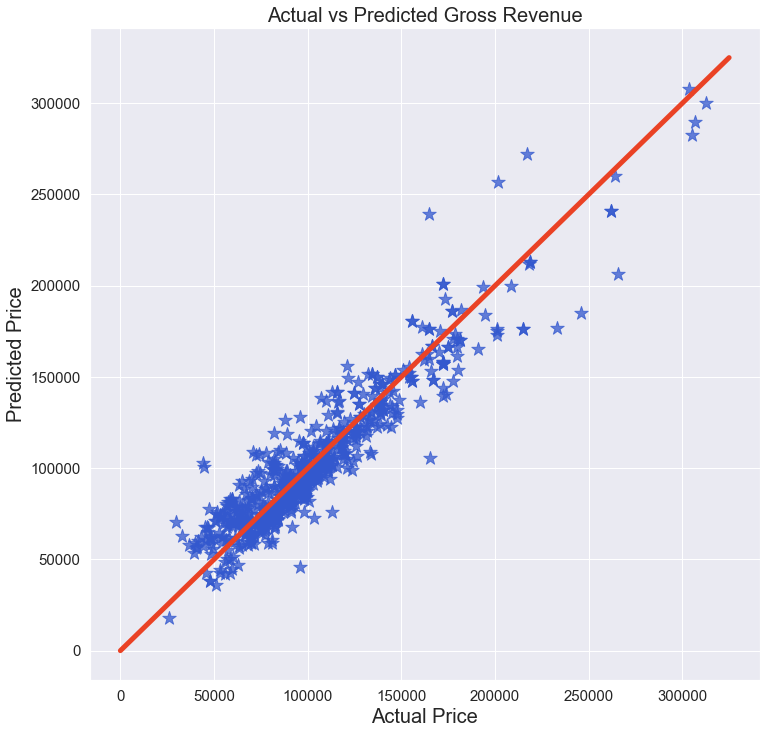

In [57]:
actual_vs_pred(y_train, fit.predict())

### Investigate large absolute residuals

- It looks like there are a few values that skew heavily from the normal distribution.
- Is it possible that these are outliers? How do they intersect with the outliers defined previously (section 3.3)?
    - What do these shows look like? Would it be valid to remove them from the dataset?

In [79]:
large_resid = fit.resid.sort_values()[:5].append(fit.resid.sort_values()[-5:])

In [80]:
large_resid

796   -74934.47
821   -58663.27
761   -56169.97
795   -55588.67
713   -55129.73
698    49895.58
172    56512.52
793    59424.05
594    59771.69
852    60761.51
dtype: float64

In [81]:
resid_outlier_indices = set(outlier_dict.keys()).intersection(set(large_resid.index))

In [82]:
resid_outlier_indices

{172, 713, 793, 795, 852}

In [62]:
ticket_final_df.iloc[list(outlier_dict.keys()),:].sort_values(by='gross_usd')

,event_date,year,month,season,day_of_week,time_of_week,num_shows,show_type,headliner,support,num_support,tickets_sold,gross_usd,venue_capacity,percentage_sold,ticket_price_min,ticket_price_max,artist_start_date,years_active,artist_hometown,us_region,local_or_not,miles_from_home,artist_genre,main_genre
23,2009-05-19,2009,May,Spring,Tuesday,Weekday,1,single headliner,John Vanderslice,No support,0,279.0,4464.000,300.0,93.0,16.00,16.00,2000.0,9,"Gainesville, Florida, United States",South,US,2349.097,Rock,experimental rock
595,2016-12-31,2016,December,Winter,Saturday,Weekend,1,single headliner,Primus,"Duo De Twang, Primus, The Claypool Lennon Deli...",3,2932.0,191074.000,2932.0,100.0,49.50,69.50,1990.0,26,"El Sobrante, California, United States",West Coast,Local,11.628,Metal,funk metal
589,2016-12-12,2016,December,Winter,Monday,Weekday,1,single headliner,Snoop Dogg,"Bone Thugs-N-Harmony, Dru Down, Luniz, Warren G",4,2828.0,193462.000,2828.0,100.0,69.50,89.50,1993.0,23,"Long Beach, California, United States",West Coast,US,360.527,Hip Hop,hip hop
295,2013-10-12,2013,October,Autumn,Saturday,Weekend,1,single headliner,Jack Johnson,Bahamas,1,2800.0,194600.000,2800.0,100.0,69.50,69.50,2000.0,13,"Hauʻula, Hawaii, United States",Hawaii,US,2395.678,Folk,folk
459,2015-09-26,2015,September,Autumn,Saturday,Weekend,1,single headliner,Grace Jones,DJ Omar,1,2800.0,197500.000,2800.0,100.0,55.00,75.00,1977.0,38,"Saint Catherine, Jamaica",International,International,3045.613,Soul,soul
541,2016-06-22,2016,June,Summer,Wednesday,Weekday,1,single headliner,Mudcrutch,The Shelters,1,2800.0,200165.000,2800.0,100.0,69.50,89.50,2008.0,8,"Gainesville, Florida, U.S.",South,US,2347.654,Rock,southern rock
43,2009-09-30,2009,September,Autumn,Wednesday,Weekday,2,multiple shows,Kylie Minogue,No support,0,2640.0,200854.500,2796.0,94.5,58.50,79.50,1988.0,21,"Melbourne, Victoria, Australia",International,International,7865.387,Pop,dance-pop
44,2009-10-01,2009,October,Autumn,Thursday,Weekend,2,multiple shows,Kylie Minogue,No support,0,2640.0,200854.500,2796.0,94.5,58.50,79.50,1988.0,21,"Melbourne, Victoria, Australia",International,International,7865.387,Pop,dance-pop
250,2012-12-31,2012,December,Winter,Monday,Weekday,1,single headliner,Erykah Badu,"Syd Tha Kyd, The Coup",2,2800.0,201033.000,2800.0,100.0,59.50,75.00,1997.0,15,"Dallas, Texas, United States",South,US,1475.957,Soul,soul
795,2018-12-31,2018,December,Winter,Monday,Weekday,1,single headliner,Lauryn Hill,No support,0,1890.0,201408.000,1890.0,100.0,99.50,149.50,1998.0,20,"South Orange, New Jersey, United States",Northeast,US,2549.759,Hip Hop,hip hop


### VIF - check for multicollinearity

- VIF is used to verify that none of the features are collinear.  
- Since the VIF factor never exceeds 5, non of the features are collinear.

In [63]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_tr.values, i) for i in range(X_tr.shape[1])]
vif["features"] = X_tr.columns

In [64]:
vif.round(1)

,VIF Factor,features
0,1.2,num_shows
1,2.1,ticket_price_min
2,1.8,ticket_range
3,1.8,venue_capacity
4,2.1,years_active
5,1.4,month_August
6,1.7,month_December
7,1.7,month_February
8,1.4,month_January
9,1.4,month_July


# Regularization

- Use to identify any weak features and additionally prevent overfitting
- Lasso can be used to try and identify weak features and is ultimately the best model (lowest MAE)

In [65]:
def lin_reg_coeffs(X_train_std, X_train, y_train, model_to_fit):
    
    # Fit model and determine beta coefficients
    alphavec = 10**np.linspace(-2,2,200)
    
    if model_to_fit == LassoCV:
        fit_model = model_to_fit(alphas = alphavec, cv=5, random_state=42)
    else:
        fit_model = model_to_fit(alphas = alphavec, cv=5)   
    
    fit_model.fit(X_train, y_train)
    beta_coefficients = list(zip(X_train.columns, fit_model.coef_))

    X_train_std_df = X_train_std.describe()[2:3]
    X_train_std_df = X_train_std_df.T['std']

    pd.options.display.float_format = '{:.2f}'.format
    beta_coeff_df = pd.DataFrame(beta_coefficients, columns = ['feature', 'beta_scaled'])
    beta_coeff_df['std'] = X_train_std_df.values
    beta_coeff_df['beta_unscaled'] = beta_coeff_df['beta_scaled']/beta_coeff_df['std']

    print('r2 score:', fit_model.score(X_train, y_train))
    print('MAE: $', mean_absolute_error(y_train, fit_model.predict(X_train)))
    print('RMSE: $', np.sqrt(mean_squared_error(y_train, fit_model.predict(X_train))))

    return fit_model, beta_coeff_df

## Ridge

In [66]:
ridge_model, ridge_beta_coeffs = lin_reg_coeffs(X_train, X_tr, y_train, RidgeCV)

r2 score: 0.8743844383864887
MAE: $ 10812.396813888148
RMSE: $ 14607.80388002487


## Lasso

In [67]:
lasso_model, lasso_beta_coeffs = lin_reg_coeffs(X_train, X_tr, y_train, LassoCV)

r2 score: 0.874353462065613
MAE: $ 10759.09704602673
RMSE: $ 14609.604883507054


## ElasticNet

In [68]:
elastic_model, elastic_beta_coeffs = lin_reg_coeffs(X_train, X_tr, y_train, ElasticNetCV)

r2 score: 0.8742451590805089
MAE: $ 10825.150447293374
RMSE: $ 14615.900015186498


# Final Model Evaluation

---
- **mean absolute error is $10,281, which is about a 10% error on average**
---

In [69]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [88]:
print('r2 score:', round(lasso_model.score(X_te, y_test), 2))

r2 score: 0.91


In [70]:
mae = mean_absolute_error(y_test, test_set_pred)
mae

10281.083159064237

In [71]:
mae/y_test.mean()

0.09962644694643089

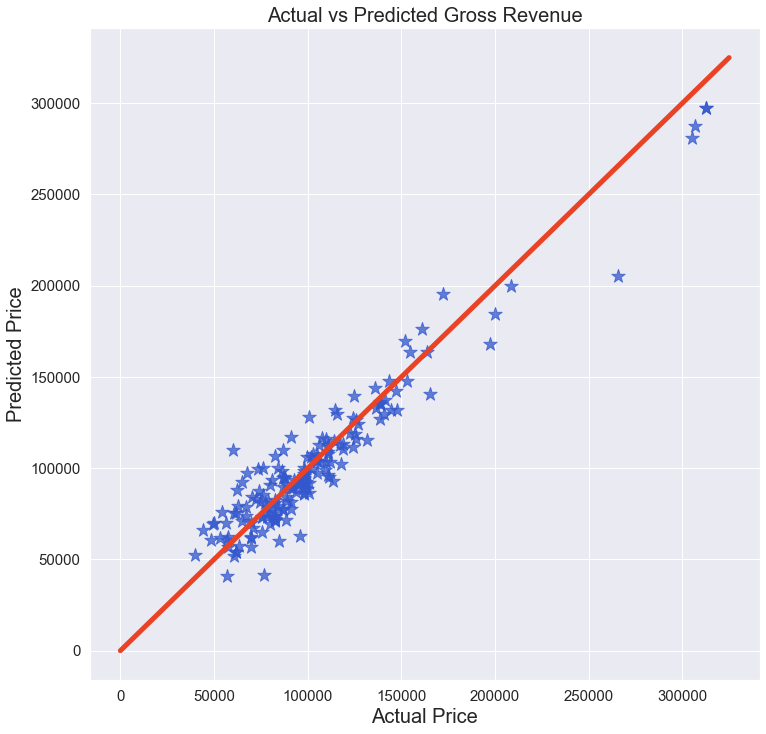

In [72]:
actual_vs_pred(y_test, test_set_pred)

## Beta Coefficients

In [96]:
print('Intercept: $', int(round(lasso_model.intercept_)))

Intercept: $ 102468


In [73]:
lasso_beta_coeffs.sort_values(by='beta_unscaled', inplace=True)

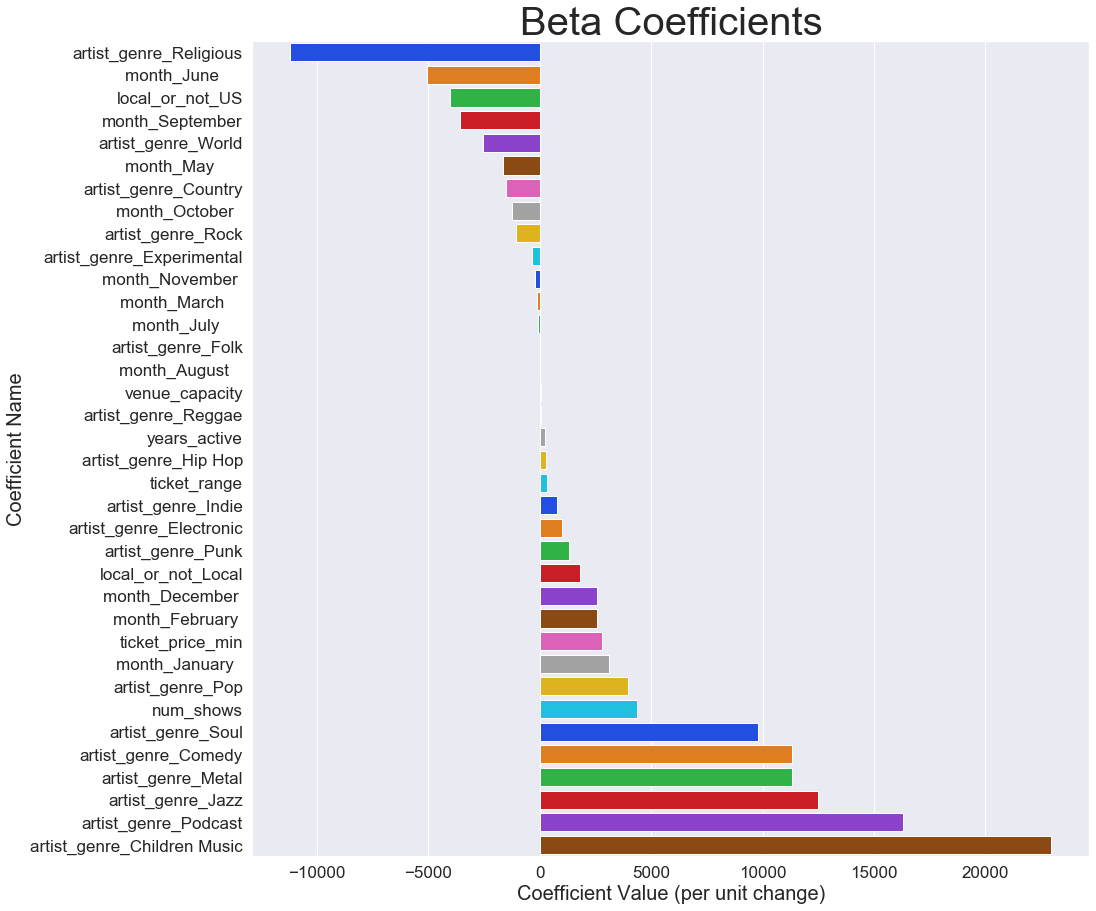

In [74]:
# Plot beta coefficients:

plt.figure(figsize=(15, 15))
plt.grid(axis='x', linestyle = '-')
sns.barplot(x = lasso_beta_coeffs.beta_unscaled.values,y=lasso_beta_coeffs.feature.values, palette = "bright")    \
            .set(yticklabels = lasso_beta_coeffs.feature.values)
plt.title('Beta Coefficients', fontsize = 40)
plt.xlabel('Coefficient Value (per unit change)', fontsize = 20)
plt.ylabel('Coefficient Name', fontsize = 20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
# for i in beta_coeffs:
#     bars.text(i.name,i.tip, round(i.total_bill,2), color='black', ha="center")
plt.show()

### LARS Path

In [75]:
# from sklearn.linear_model import lars_path

In [76]:
# X_for_lars = X_tr_scaled[:,:7]
# X_for_lars_legend = ['Num_Support', 'Venue_Capacity', 'Ticket_Price_Min', 'Ticket_Price_Max']

In [77]:
# alphas, _, coefs = lars_path(X_for_lars, pd.Series(y_train).values, method='lasso')

In [78]:
# plotting the LARS path

# xx = np.sum(np.abs(coefs.T), axis=1)
# xx /= xx[-1]

# plt.figure(figsize=(10,10))
# plt.plot(xx, coefs.T)
# ymin, ymax = plt.ylim()
# plt.vlines(xx, ymin, ymax, linestyle='dashed')
# plt.xlabel('|coef| / max|coef|')
# plt.ylabel('Coefficients')
# plt.title('LASSO Path')
# plt.axis('tight')
# plt.legend(X_for_lars_legend)
# plt.show()